# Classify ALS status using AFQ-Insight

In [1]:
import afqinsight as afqi
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import palettable
import pickle

from matplotlib.colors import to_hex
from mpl_toolkits.mplot3d import Axes3D

from bokeh.io import output_notebook, reset_output
from bokeh.embed import file_html
from bokeh.layouts import row, column, widgetbox
from bokeh.models import BoxSelectTool, HoverTool, Legend, Title, Range1d, CustomJS, ColorBar
from bokeh.models.tickers import FixedTicker
from bokeh.models.mappers import LinearColorMapper
from bokeh.palettes import Spectral10, RdBu, Category10
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.resources import CDN
from bokeh.transform import factor_cmap
from bokeh.models import BoxAnnotation, Label

from sklearn.decomposition import PCA

%matplotlib notebook

In [2]:
output_notebook()

Loading BokehJS ...

## Load the data

In [3]:
afq_data = afqi.load_afq_data(
    '../data/raw/als_data',
    target_cols=['class'],
    binary_positives={'class': 'ALS'},
    scale_x=False
)

x, y, groups, columns, bias_index = (
    afq_data.x,
    afq_data.y['class'],
    afq_data.groups,
    afq_data.columns,
    afq_data.bias_index
)

/Users/richford/miniconda3/envs/afq-insight/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/richford/projects/neuro/afq/insight/afqinsight/transform.py:145: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  features.columns.labels[metric_level].astype(np.int64) * n_tracts
/Users/richford/projects/neuro/afq/insight/afqinsight/transform.py:146: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  + features.columns.labels[tract_level].astype(np.int64),


In [4]:
y

subjectID
subject_000    1
subject_001    1
subject_002    1
subject_003    1
subject_004    1
subject_005    1
subject_006    1
subject_007    1
subject_008    1
subject_009    1
subject_010    1
subject_011    1
subject_012    1
subject_013    1
subject_014    1
subject_015    1
subject_016    1
subject_017    1
subject_018    1
subject_019    1
subject_020    1
subject_021    1
subject_022    1
subject_023    1
subject_024    0
subject_025    0
subject_026    0
subject_027    0
subject_028    0
subject_029    0
subject_030    0
subject_031    0
subject_032    0
subject_033    0
subject_034    0
subject_035    0
subject_036    0
subject_037    0
subject_038    0
subject_039    0
subject_040    0
subject_041    0
subject_042    0
subject_043    0
subject_044    0
subject_045    0
subject_046    0
subject_047    0
Name: class, dtype: int64

In [5]:
label_sets = afqi.multicol2sets(columns, tract_symmetry=True)
select_labels = [["fa"], ["md"]]
x_md_fa = afqi.select_groups(np.delete(x, bias_index, axis=1), select_labels, label_sets)

In [6]:
x_md_fa = np.hstack([x_md_fa, x[:, bias_index][:, np.newaxis]])

## Find the optimal feature coefficients $\widehat{\beta}$

We search for the optimal coefficients using two different classification scores: accuracy and ROC AUC.

In [7]:
# for max_cv in range(1400, 2501, 100):
#     hp_cv_res_acc = afqi.fit_hyperparams_cv(
#         x, y, groups, bias_index=bias_index,
#         max_evals_per_cv=max_cv,
#         score='accuracy',
#         trials_pickle_dir='./trials_classification/cv10_rs42_accuracy',
#         verbose=1, random_state=42, clf_threshold=0.5
#     )

In [8]:
hp_cv_res_acc = afqi.fit_hyperparams_cv(
    x, y, groups, bias_index=bias_index,
    n_splits=10, n_repeats=3,
    max_evals_per_cv=100,
    score='accuracy',
    trials_pickle_dir='./trials_classification/cv3x10_v2_rs42_scaled_accuracy',
    verbose=1, random_state=42, clf_threshold=0.5
)

0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]



In [9]:
hp_cv_res_acc_md_fa = afqi.fit_hyperparams_cv(
    x_md_fa, y, groups[:40], bias_index=4000,
    n_splits=10, n_repeats=3,
    max_evals_per_cv=100,
    score='accuracy',
    trials_pickle_dir='./trials_classification/cv3x10_v2_rs42_scaled_accuracy_md_fa_only',
    verbose=1, random_state=42, clf_threshold=0.5
)

0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]



In [10]:
# hp_cv_res_auc = afqi.fit_hyperparams_cv(
#     x, y, groups, bias_index=bias_index,
#     n_splits=10, n_repeats=3,
#     max_evals_per_cv=250,
#     score='roc_auc',
#     trials_pickle_dir='./trials_classification/cv3x10_v2_rs42_scaled_rocauc',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [11]:
cv = hp_cv_res_acc_md_fa[0]

In [12]:
def print_results_summary(hp_cv_results):
    template = '{stat:15s} {mean:7.5g} ({var:7.5g})'
    test = [r.test for r in hp_cv_results]
    train = [r.train for r in hp_cv_results]
    test_acc = [t.accuracy for t in test]
    test_auc = [t.auc for t in test]
    test_aps = [t.avg_precision for t in test]
    train_acc = [t.accuracy for t in train]
    train_auc = [t.auc for t in train]
    train_aps = [t.avg_precision for t in train]

    print('Statistic         mean   (variance)')
    print('--------------  ------- ------------')
    print(template.format(stat='test accuracy', mean=np.mean(test_acc), var=np.var(test_acc)))
    print(template.format(stat='test AUC', mean=np.mean(test_auc), var=np.var(test_auc)))
    print(template.format(stat='test avg prec', mean=np.mean(test_aps), var=np.var(test_aps)))
    print(template.format(stat='train accuracy', mean=np.mean(train_acc), var=np.var(train_acc)))
    print(template.format(stat='train AUC', mean=np.mean(train_auc), var=np.var(train_auc)))
    print(template.format(stat='train avg prec', mean=np.mean(train_aps), var=np.var(train_aps)))

In [13]:
print_results_summary(hp_cv_res_acc)

Statistic         mean   (variance)
--------------  ------- ------------
test accuracy   0.69167 (0.050532)
test AUC        0.78796 (0.057278)
test avg prec    0.8637 (0.021222)
train accuracy        1 (      0)
train AUC             1 (      0)
train avg prec        1 (4.9304e-32)


In [14]:
print_results_summary(hp_cv_res_acc_md_fa)

Statistic         mean   (variance)
--------------  ------- ------------
test accuracy   0.80833 (0.017662)
test AUC        0.91204 (0.015951)
test avg prec    0.9363 (0.0091373)
train accuracy        1 (      0)
train AUC             1 (      0)
train avg prec        1 (4.9304e-32)


In [15]:
# print_results_summary(hp_cv_res_auc)

In [16]:
import pandas as pd

In [17]:
test_set_y_hat = pd.concat([
    pd.Series(data=afqi.insight._sigmoid(cv.test.x.dot(cv.beta_hat)),
              index=cv.test.y.index,
              name='yhat')
    for cv in hp_cv_res_acc_md_fa
]).groupby('subjectID').mean()

In [18]:
y_y_hat = pd.concat([y, test_set_y_hat], axis='columns', sort=True)
y_y_hat['index'] = np.arange(len(y), dtype=np.int32)
y_y_hat.sort_values(['class', 'yhat'], inplace=True)
y_y_hat['sorted_index'] = np.arange(len(y_y_hat))

In [19]:
import beeswarm as bs

In [20]:
list_of_preds = [y_y_hat.loc[y_y_hat['class'] == 0, 'yhat'].values, y_y_hat.loc[y_y_hat['class'] == 1, 'yhat'].values]

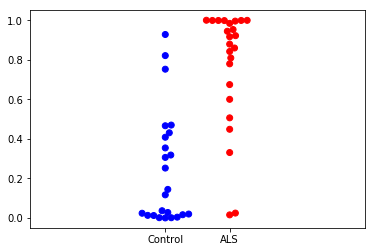

In [21]:
df_bs, ax = bs.beeswarm(list_of_preds, s=23, method='swarm', positions=[0, 0.05], labels=['Control', 'ALS'], col=['blue', 'red'])

In [22]:
df_bs.rename(columns=lambda x: 'yhat' if x == 'yorig' else x, inplace=True)
df_bs.columns
df_bs.sort_values(['xorig', 'yhat'], inplace=True)
df_bs['sorted_index'] = np.arange(len(df_bs))

In [23]:
df_yhat = y_y_hat.join(df_bs, on='sorted_index', rsuffix='_bs')
df_yhat.drop(['sorted_index', 'sorted_index_bs', 'xorig', 'yhat_bs'], axis='columns', inplace=True)
df_yhat['predicted_class_text'] = df_yhat['yhat'].map(lambda x: 'Predicted ALS' if x > 0.5 else 'Predicted Control')
df_yhat.loc[df_yhat['yhat'] <= 0.5, 'color'] = 'blue'
df_yhat.loc[df_yhat['yhat'] > 0.5, 'color'] = 'red'
df_yhat.head()

,class,yhat,index,xnew,ynew,color,predicted_class_text
subjectID,,,,,,,
subject_034,0,0.000008,34,0.000000,0.000008,blue,Predicted Control
subject_040,0,0.000910,40,0.004653,0.000910,blue,Predicted Control
subject_028,0,0.001113,28,-0.004652,0.001113,blue,Predicted Control
subject_046,0,0.003852,46,0.009287,0.003852,blue,Predicted Control
subject_024,0,0.012169,24,-0.008987,0.012169,blue,Predicted Control


In [24]:
width=600
height=600
p = figure(plot_width=width, plot_height=height, toolbar_location='above',
           tools="save", x_range=(-0.015, 0.06))
p.title.text = 'A'

p.y_range = Range1d(0, 1)

source = ColumnDataSource(data=df_yhat)

c0 = p.circle(source=source, x='xnew', y='ynew',
              size=15, legend='predicted_class_text', color='color')

l = p.line(x=[-0.015, 0.06], y=[0.5, 0.5], line_width=2, color='black', line_dash='dashed')
hover = HoverTool(
    tooltips=[("Subject", "@index"),
              ("P(ALS)", "@yhat")],
    renderers=[c0]
)
hover.point_policy = 'snap_to_data'
hover.line_policy = 'nearest'

p.add_tools(hover)
p.legend.location = 'bottom_right'

p.xaxis.axis_label = "Class"
p.xaxis.ticker = FixedTicker(ticks=[0, 0.05])
p.xaxis.major_label_overrides = {0: 'Control', 0.05: 'ALS'}
p.xaxis.major_label_text_font_size = "14pt"
p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
#p.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels
p.yaxis.axis_label = "Classification Probability"
p.title.text_font_size = "16pt"
p.xaxis.axis_label_text_font_size = "16pt"
p.yaxis.axis_label_text_font_size = "16pt"
p.yaxis.major_label_text_font_size = "14pt"

# output_html = "../docs/img/bokeh_plots/classification_probs_acc_small.html"
# if output_html is not None:
#     html = file_html(p, CDN, "my plot")
#     with open(op.abspath(output_html), 'w') as fp:
#         fp.write(html)
show(p)

In [25]:
width=175
height=200
p = figure(plot_width=width, plot_height=height, toolbar_location='above',
           tools="")
p.title.text = 'Test split classification probabilities'

p.y_range = Range1d(0, 1)

source = ColumnDataSource(data=df_yhat)

c0 = p.circle(source=source, x='xnew', y='ynew',
              size=7, color='color')

hover = HoverTool(
    tooltips=[("Subject", "@index"),
              ("P(ALS)", "@yhat")],
    renderers=[c0]
)
hover.point_policy = 'snap_to_data'
hover.line_policy = 'nearest'

p.add_tools(hover)
#p.legend.location = 'bottom_right'

p.xaxis.axis_label = "Class"
p.xaxis.ticker = FixedTicker(ticks=[0, 0.05])
p.xaxis.major_label_overrides = {0: 'Control', 0.05: 'ALS'}
p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
#p.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels
p.yaxis.axis_label = "Classification Probability"
p.title.text_font_size = "4pt"
p.xaxis.axis_label_text_font_size = "8pt"
p.yaxis.axis_label_text_font_size = "8pt"

output_html = "../docs/img/bokeh_plots/classification_probs_acc_tiny.html"
if output_html is not None:
    html = file_html(p, CDN, "my plot")
    with open(op.abspath(output_html), 'w') as fp:
        fp.write(html)
# show(p)

Using the hover tool on the chart above, we can see that subjects 05, 16, 19, 32, 35, 36 are all hard to classify (i.e. they are closer to the classification threshold of 0.5). We should fire up the AFQ browser and look at how these subjects compare to the rest of the subjects in their group.

Here are links to a running instance of AFQ-Browser with the hard to classify subjects:
- [False negatives](https://yeatmanlab.github.io/Sarica_2017/?table[prevSort][count]=2&table[prevSort][order]=ascending&table[prevSort][key]=&table[sort][count]=2&table[sort][order]=ascending&table[sort][key]=class&table[selectedRows][subject_005]=true&table[selectedRows][subject_016]=true&table[selectedRows][subject_019]=true&table[selectedRows][subject_030]=false&table[selectedRows][subject_032]=false&table[selectedRows][subject_035]=false&table[selectedRows][subject_036]=false&plots[checkboxes][right-corticospinal]=true&plots[zoom][rd][scale]=1&plots[zoom][rd][translate][0]=-3&plots[zoom][rd][translate][1]=-21&plots[zoom][fa][scale]=2.1140360811227614&plots[zoom][fa][translate][0]=-27.244995845837778&plots[zoom][fa][translate][1]=-106.10468474511174&plots[plotKey]=fa&plots[errorType]=stderr&plots[lineOpacity]=0.0)
- [False positives](https://yeatmanlab.github.io/Sarica_2017/?table[prevSort][count]=2&table[prevSort][order]=ascending&table[prevSort][key]=&table[sort][count]=2&table[sort][order]=ascending&table[sort][key]=class&table[selectedRows][subject_005]=false&table[selectedRows][subject_007]=false&table[selectedRows][subject_016]=false&table[selectedRows][subject_019]=false&table[selectedRows][subject_032]=true&table[selectedRows][subject_035]=true&table[selectedRows][subject_036]=true&plots[checkboxes][right-corticospinal]=true&plots[zoom][rd][scale]=1&plots[zoom][rd][translate][0]=-3&plots[zoom][rd][translate][1]=-21&plots[zoom][fa][scale]=2.1140360811227614&plots[zoom][fa][translate][0]=-27.244995845837778&plots[zoom][fa][translate][1]=-106.10468474511174&plots[plotKey]=fa&plots[errorType]=stderr&plots[lineOpacity]=0.0)

# Feature Importance

Let's sort the features by their importance

In [26]:
columns_md_fa = columns.drop(['ad', 'cl', 'curvature', 'rd', 'torsion', 'volume'], level=0)
columns_md_fa = columns_md_fa.remove_unused_levels()

In [69]:
feature_dicts = afqi.multicol2dicts(columns_md_fa, tract_symmetry=False)
mean_beta = np.mean(np.array([np.delete(res.beta_hat, 4000) for res in hp_cv_res_acc_md_fa]),
                    axis=0)

var_beta = np.std(np.array([np.delete(res.beta_hat, 4000) for res in hp_cv_res_acc_md_fa]),
                    axis=0)

sorted_features = afqi.sort_features(feature_dicts, mean_beta)

It's nice to see the top few features in a sorted list, but let's plot the features to get a feel for their distributions

In [70]:
betas_by_group = afqi.beta_hat_by_groups(mean_beta, columns=columns_md_fa, drop_zeros=True)
betas_by_group_var = afqi.beta_hat_by_groups(var_beta, columns=columns_md_fa, drop_zeros=True)

First let's plot the coefficients themselves

In [79]:
unfolded_beta = afqi.transform.unfold_beta_hat_by_metrics(
    beta_hat=mean_beta,
    columns=columns_md_fa
)

unfolded_beta_std = afqi.transform.unfold_beta_hat_by_metrics(
    beta_hat=var_beta,
    columns=columns_md_fa
)

In [82]:
unfolded_beta_with_err = {
    'fa': unfolded_beta['fa'],
    'fa_hi': unfolded_beta['fa'] + unfolded_beta_std['fa'],
    'fa_lo': unfolded_beta['fa'] - unfolded_beta_std['fa'],
    'md': unfolded_beta['md'],
    'md_hi': unfolded_beta['md'] + unfolded_beta_std['md'],
    'md_lo': unfolded_beta['md'] - unfolded_beta_std['md'],
}

In [86]:
width = 1150
height = 700
output_html = None

p = figure(plot_width=width, plot_height=height, toolbar_location='above',
              tools="save")
p.title.text = 'Feature weights in the "unfolded" brain'

len_alltracts = len(unfolded_beta[list(unfolded_beta.keys())[0]])
n_tracts = len(afqi.utils.canonical_tract_names)
n_nodes = len_alltracts / n_tracts
ticks = np.arange(0, len_alltracts, n_nodes)

p.xaxis.ticker = FixedTicker(ticks=[ticks[4] + n_nodes/2, ticks[-4] - n_nodes/2],
                             minor_ticks=[ticks[0], ticks[9], ticks[11], ticks[-1] + n_nodes])
p.xaxis.major_label_overrides = {int(ticks[4] + n_nodes/2): 'Left Hemisphere',
                                 int(ticks[-4] - n_nodes/2): 'Right Hemisphere'}

p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
p.xaxis.major_tick_line_color = None  # turn off x-axis major ticks

p.xaxis.major_label_text_font_size = '14pt'  # turn off x-axis tick labels

p.x_range = Range1d(0, len_alltracts)
p.xgrid.grid_line_color = None

tract_colors = np.copy(palettable.tableau.Tableau_20.hex_colors).tolist()
tract_colors = (tract_colors[1:-2:2]
                + tract_colors[-2:]
                + tract_colors[-3::-2])

for i, color in enumerate(tract_colors):
    p.add_layout(BoxAnnotation(
        left=ticks[i], right=ticks[i] + n_nodes,
        fill_color=color, fill_alpha=0.15
    ))

    p.add_layout(Label(
        x=ticks[i] + n_nodes / 2,
        y=10,
        x_units='data',
        y_units='screen',
        text=afqi.utils.canonical_tract_names[i].replace('Left ', '').replace('Right ',''),
        render_mode='canvas',
        border_line_alpha=0.0,
        background_fill_alpha=0.0,
        angle=np.pi / 2,
        text_align='left',
        text_baseline='middle'
    ))

p.add_layout(BoxAnnotation(
    left=ticks[0], right=ticks[9],
    fill_color=None, fill_alpha=0.0,
    line_color="black", line_width=4
))
p.add_layout(BoxAnnotation(
    left=ticks[9], right=ticks[11],
    fill_color=None, fill_alpha=0.0,
    line_color="black", line_width=4
))
p.add_layout(BoxAnnotation(
    left=ticks[11], right=ticks[-1] + n_nodes,
    fill_color=None, fill_alpha=0.0,
    line_color="black", line_width=4
))
    
unfolded_beta_with_err['x'] = np.arange(len_alltracts)
source = ColumnDataSource(data=unfolded_beta_with_err)
del unfolded_beta_with_err['x']

lines = {}
for name, color in zip(
        unfolded_beta.keys(),
        Category10[max(len(list(unfolded_beta.keys())),
                       min(list(Category10.keys())))]
):
    lines[name] = p.line(
        x='x', y=name, source=source, name=name,
        line_width=3, color=color
    )
    lines[name + '_hi'] = p.line(
        x='x', y=name + '_hi', source=source, name=name,
        line_width=1, color=color
    )
    lines[name + '_lo'] = p.line(
        x='x', y=name + '_lo', source=source, name=name,
        line_width=1, color=color
    )

p.add_tools(HoverTool(
    show_arrow=False,
    line_policy='interp',
    tooltips=[
        ('metric', '$name'),
        ('beta', '$y'),
    ],
    point_policy='snap_to_data',
    renderers=list(lines.values())
))

legend = Legend(items=[
    (name, [renderer]) for name, renderer in lines.items()
], location=(0, 70))

p.add_layout(
    Title(text='Click on legend entries to hide/show lines',
          align="left"), 'right'
)
p.add_layout(legend, 'right')
p.legend.click_policy = 'hide'

p.title.text_font_size = "18pt"
p.yaxis.axis_label = "β"
p.yaxis.axis_label_text_font_size = "18pt"

# output_html = "../docs/img/bokeh_plots/classification_unfolded_beta.html"
# if output_html is not None:
#     html = file_html(p, CDN, "my plot")
#     with open(op.abspath(output_html), 'w') as fp:
#         fp.write(html)

show(p)

In [73]:
betas_by_group['Left Arcuate']

OrderedDict([('fa',
              array([ 3.33479807e-03, -1.02341720e-04,  0.00000000e+00,  1.20045873e-04,
                      0.00000000e+00,  0.00000000e+00, -5.38210127e-05, -1.04723498e-04,
                     -1.39198205e-04, -5.03202323e-04, -1.08844017e-03, -2.03750915e-03,
                     -2.54004834e-03, -1.67291502e-03, -1.43021564e-03, -1.80218812e-03,
                     -4.94744655e-03, -1.13250646e-02, -1.27807995e-02, -1.17456325e-02,
                     -4.30330505e-03, -6.50254911e-04,  1.01578766e-04,  8.32258040e-04,
                      1.19766777e-03,  1.43188271e-03,  1.88514026e-03,  2.97593211e-03,
                      3.70433340e-03,  4.38499001e-03,  5.13996552e-03,  5.08789702e-03,
                      4.08420502e-03,  2.06589730e-03,  8.16252523e-04,  3.68996046e-04,
                      3.58236975e-04,  6.21688821e-04,  9.99853922e-04,  1.27327019e-03,
                      1.20865471e-03,  9.33876669e-04,  6.51402797e-04,  4.31471582e-04,
 

In [87]:
from dipy.viz import window, actor
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
from dipy.tracking.streamline import transform_streamlines

import json

In [88]:
with open("../data/raw/core_streamlines.json") as fp:
    cores = json.load(fp)

In [99]:
metric = "fa"

renderer = window.Renderer()
renderer.background((1, 1, 1))
colors = np.concatenate([betas_by_group[bn][metric]
                         for bn in betas_by_group.keys()])
bundle_names = betas_by_group.keys()
bundles = [np.array(cores[bn]["coreFiber"]) for bn in bundle_names]
stream_actor = actor.line(
    lines=bundles,
    colors=actor.create_colormap(colors, name='PuOr', auto=True),
    linewidth=20,
    spline_subdiv=300,
    fake_tube=True,
)

renderer.add(stream_actor)
window.show(renderer, size=(900, 900), reset_camera=True)

In [67]:
actor.create_colormap(colors, name='coolwarm', auto=True)[115]

array([0.9682034 , 0.7208441 , 0.61229299])

In [66]:
colors[115]

0.0

TypeError: SetBackground argument 1: expected a sequence of 3 values, got 5 values